**Isaias Chavarria Mora**

**Model**

In [306]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
import glob
from collections import defaultdict
import os
from itertools import combinations
import csv
import gc
import matplotlib.pyplot as plt

In [307]:
BASE_PATH_DIRECTORY = ".." + os.sep + "train"
TEST_BASE_PATH_DIRECTORY = ".." + os.sep + "test"
SUBMISSIONS_RESULTS_FILE_NAME = ".." + os.sep + 'result_submissions.csv'
SUBMISSIONS_SAMPLE_FILE_NAME = ".." + os.sep + 'sample_submission.csv'
TRAINING_DATA_COMPLETED_FILE = ".." + os.sep + 'training_data_ready_for_nn_large.csv'
TRAINING_DATA_SPLITTED_FILE = ".." + os.sep + 'training_data.csv'
VALIDATION_DATA_SPLITTED_FILE = ".." + os.sep + 'validation_data.csv'

In [308]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),#224,224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"WORKING ON {device} ")


WORKING ON cuda:0 


# DATA LOADER

Create a class to allow data loader to submit each row on the training pairs
The pairs will be
1. P1: Person 1 photo
2. P2: Person 2 Photo
3. Label: Indicator if those people are related o not

In [309]:
class ImagePairDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #0 = "P1"
        #1 = "P2"
        #2 = "result"
        
        P1_path = str(self.data.iloc[idx, 0])
        P2_path = str(self.data.iloc[idx, 1])
        label = self.data.iloc[idx, 2]

        P1_image = Image.open(P1_path).convert('RGB')
        P2_image = Image.open(P2_path).convert('RGB')
        if self.transform:
          P1_image = self.transform(P1_image)
          P2_image = self.transform(P2_image)
          
        return P1_image, P2_image, torch.tensor(label, dtype=torch.float32)

# Model Class

**What is ResNet-50?**

ResNet-50 is CNN architecture that belongs to the ResNet (Residual Networks) family, a series of models designed to address the challenges associated with training deep neural networks. Developed by researchers at Microsoft Research Asia, ResNet-50 is renowned for its depth and efficiency in image classification tasks. ResNet architectures come in various depths, such as ResNet-18, ResNet-32, and so forth, with ResNet-50 being a mid-sized variant.

ResNet-50 was released in 2015, but remains a notable model in the history of image classification.

https://blog.roboflow.com/what-is-resnet-50/

In [310]:
class RelationshipNetwork(nn.Module):
    def __init__(self):
        super(RelationshipNetwork, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove final classification layer
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            #nn.Linear(2048, 512),
            nn.ReLU(),
            #nn.Linear(512, 1),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        return self.resnet(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        distance = torch.abs(output1 - output2)
        out = self.fc(distance)
        return out

In [311]:
def load_dataset(csv_file, batch_size=32):
    dataset = ImagePairDataset(csv_file, transform=transform)
    #return DataLoader(dataset, batch_size=batch_size, num_workers=4, pin_memory=True) #, collate_fn=collate_fn)
    return DataLoader(dataset, batch_size=batch_size) #, collate_fn=collate_fn)

In [312]:
# dataset = ImagePairDataset(TRAINING_DATA_COMPLETED_FILE, transform=transform)
# print(len(dataset))
# print(dataset.__getitem__(50))
# print("ImagePairDataset OK")

# TEST MODEL

In [313]:
#Read the submissions image pairs
submission_data = pd.read_csv(SUBMISSIONS_SAMPLE_FILE_NAME)
submission_data['p1'] = submission_data.img_pair.apply( lambda x: TEST_BASE_PATH_DIRECTORY + os.sep + x.split('-')[0])
submission_data['p2'] = submission_data.img_pair.apply( lambda x: TEST_BASE_PATH_DIRECTORY + os.sep + x.split('-')[1] )
print(submission_data.shape)
submission_data.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,..\test\face05508.jpg,..\test\face01210.jpg
1,face05750.jpg-face00898.jpg,0,..\test\face05750.jpg,..\test\face00898.jpg
2,face05820.jpg-face03938.jpg,0,..\test\face05820.jpg,..\test\face03938.jpg
3,face02104.jpg-face01172.jpg,0,..\test\face02104.jpg,..\test\face01172.jpg
4,face02428.jpg-face05611.jpg,0,..\test\face02428.jpg,..\test\face05611.jpg


In [314]:
def test_model_images(model: torch.nn.Module, P1: str, P2: str):
    model.eval()
    with torch.no_grad():
        P1_image = transform(Image.open(P1).convert('RGB')).unsqueeze(0).to(device)
        P2_image = transform(Image.open(P2).convert('RGB')).unsqueeze(0).to(device)
        output = model(P1_image, P2_image)
        return output.item()

In [315]:
def validate_model(model: torch.nn.Module, dataloader:torch.utils.data.DataLoader, criterion: torch.nn.modules.loss):
    print("============================================================================")
    print("VALIDATION PROCESS STARTED!!")
    print("============================================================================")
    model.eval()


    total_samples = 0
    correct_predictions = 0
    valid_loss = 0.0

    with torch.no_grad():
        accuracy = 0.0
        for P1_image, P2_image, label in dataloader:
            P1_image, P2_image, label = P1_image.to(device), P2_image.to(device), label.to(device)
            
            outputs = model(P1_image, P2_image)

            loss = criterion(outputs.squeeze(), label)
            valid_loss += loss.item()

             # Get predictions
            #_, predictions = torch.max(outputs, 1)  # This line assumes you are using multi-class classification

            # Sigmoid outputs need to be thresholded at 0.5 to get binary predictions (0 or 1)
            predictions = (outputs.squeeze() > 0.5).float()  # Convert to binary

            # Update total samples and correct predictions
            correct_predictions += (predictions == label).sum().item()
            total_samples += label.size(0)
            
            validation_loss.append(valid_loss / len(dataloader))

    # Calculate average validation loss
    avg_loss = valid_loss / len(dataloader)
    
    # Calculate accuracy as a percentage
    accuracy = (correct_predictions / total_samples) * 100
    print("============================================================================")
    print(f'Finished Validation!, Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')  

In [316]:
def perform_test_process(model: torch.nn.Module):
    print("============================================================================")
    print("TEST PROCESS STARTED!!")
    print("============================================================================")
    with open(SUBMISSIONS_RESULTS_FILE_NAME, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['img_pair', 'is_related'])
        for ind in submission_data.index:
            image1_path = submission_data["p1"][ind]
            image2_path = submission_data["p2"][ind]
            is_related = test_model_images(model, image1_path, image2_path)
            image_pair = image1_path + "-" + image2_path
            csvwriter.writerow([image_pair, str(round(is_related))])
    print("TEST PROCESS COMPLETED!!")

In [318]:
# Training the model

def train_model(model: torch.nn.Module, dataloader:torch.utils.data.DataLoader, criterion: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, num_epochs=10):
    try:
        model = model.to(device)
        # Prepare the model for training
        torch.cuda.empty_cache()
        gc.collect()
        model.train()
        num_samples = len(dataloader.dataset)
        num_batches = len(dataloader)
        print("============================================================================")
        print(f"TRAINING PROCESS STARTED for {num_epochs} EPOCHS")
        print("============================================================================")

        for epoch in range(num_epochs):
            counter =0
            epoch_loss = 0.0
            epoch_accuracy = 0.0

            for P1_image, P2_image, label in dataloader:
                counter = counter + 1
                P1_image, P2_image, label = P1_image.to(device), P2_image.to(device), label.to(device)
                
                
                optimizer.zero_grad()
                
                outputs = model(P1_image, P2_image)
                #loss = criterion(outputs.squeeze(), label)
                loss = criterion(outputs.squeeze(), label)

                epoch_loss += loss.item()
                #epoch_accuracy += (torch.argmax(outputs.data, 1) == label).sum().item()

                loss.backward()
                optimizer.step()

                if(counter % 5000 == 0):
                    print(f"Progress on {counter} batches")

            print(f'Epoch [{epoch + 1}/{num_epochs}], Epoch Loss: {epoch_loss / num_batches}')
            training_loss.append(epoch_loss / num_batches)
        torch.save({'epoch':epoch, 'model_state_dict': model.state_dict(),'optimizer_state_dict':optimizer.state_dict(), 'loss':loss.item()},f'model_RESNET.pth')
    except Exception as e:
        print(f"An error occurred: {e}")

**DATA SAMPLE FOR TRAINING AND VALIDATION**

Split the data into 2 different sets.  
80% for training.  
20% for validation.  

This split is to be able to check the data against the label after training the model

In [319]:
complete_data=pd.read_csv(TRAINING_DATA_COMPLETED_FILE)
train=complete_data.sample(frac=0.8,random_state=2000000)
test=complete_data.drop(train.index)

train.to_csv(TRAINING_DATA_SPLITTED_FILE, index=False)
test.to_csv(VALIDATION_DATA_SPLITTED_FILE, index=False)

print(complete_data.head())

                                     p1                                    p2  \
0  ..\train\F0002\MID1\P00009_face3.jpg  ..\train\F0002\MID2\P00009_face2.jpg   
1  ..\train\F0002\MID1\P00009_face3.jpg  ..\train\F0002\MID2\P00010_face3.jpg   
2  ..\train\F0002\MID1\P00009_face3.jpg  ..\train\F0002\MID2\P00011_face2.jpg   
3  ..\train\F0002\MID1\P00009_face3.jpg  ..\train\F0002\MID2\P00012_face1.jpg   
4  ..\train\F0002\MID1\P00009_face3.jpg  ..\train\F0002\MID2\P00013_face1.jpg   

   result  
0       0  
1       0  
2       0  
3       0  
4       0  


# Invocation Process
1. Define Variables like epochs, learning Rate, and batch size
2. Create the model object
3. Create the loss and optimizer object
4. Call The loader
5. Train the model
6. Validate the model
7. Test the model

In [320]:
# Paths and constants
batch_size = 32
num_epochs = 10
learning_rate = 0.00001

# Initialize model, criterion, optimizer
model = RelationshipNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Load data
dataloader = load_dataset(TRAINING_DATA_SPLITTED_FILE, batch_size)

print("============================================================================")
print("Dataset Loaded Correctly!!")
print("============================================================================")

# Train the model
training_loss = []
validation_loss = []
train_model(model, dataloader, criterion, optimizer, num_epochs)

validation_loader = load_dataset(VALIDATION_DATA_SPLITTED_FILE, batch_size)
validate_model(model, validation_loader, criterion)

# Test the model and save results
perform_test_process(model)

c:\Users\isaia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\isaia\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Dataset Loaded Correctly!!
TRAINING PROCESS STARTED for 10 EPOCHS
Progress on 5000 batches
Epoch [1/10], Epoch Loss: 0.07563232398249171
Progress on 5000 batches
Epoch [2/10], Epoch Loss: 0.010857963416854851
Progress on 5000 batches
Epoch [3/10], Epoch Loss: 0.00611864553605231
Progress on 5000 batches
Epoch [4/10], Epoch Loss: 0.004471525064689964
Progress on 5000 batches
Epoch [5/10], Epoch Loss: 0.004183272872830634
Progress on 5000 batches
Epoch [6/10], Epoch Loss: 0.007970126320128662
Progress on 5000 batches
Epoch [7/10], Epoch Loss: 0.003286576340237113
Progress on 5000 batches
Epoch [8/10], Epoch Loss: 0.002993701504877592
Progress on 5000 batches
Epoch [9/10], Epoch Loss: 0.0025720181399796404
Progress on 5000 batches
Epoch [10/10], Epoch Loss: 0.002642955397897089
VALIDATION PROCESS STARTED!!
Finished Validation!, Validation Loss: 0.0111, Accuracy: 99.85%
TEST PROCESS STARTED!!
TEST PROCESS COMPLETED!!


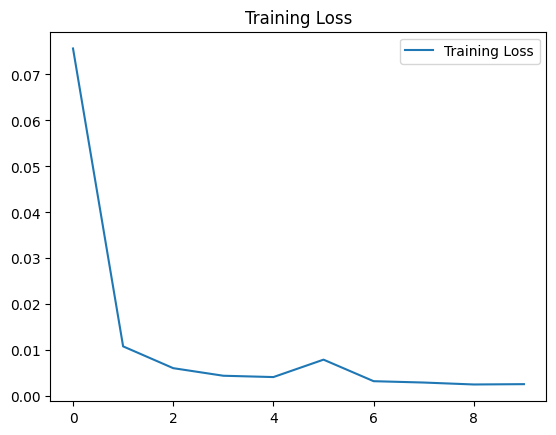

In [326]:
#create_loss_plot(loss_values=training_loss)
loss_values= training_loss #[2,3,4,5,6,7,8,1,2]
loss_values2= validation_loss #[9,6,4,8,6]
plt.plot(loss_values, label='Training Loss')
#plt.plot(loss_values2, label='Validation Loss')

plt.title("Training Loss")

plt.legend()
plt.show()

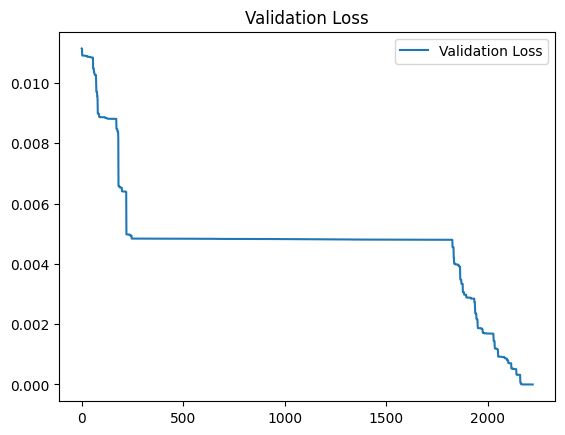

In [331]:
#create_loss_plot(loss_values=training_loss)
loss_values= training_loss #[2,3,4,5,6,7,8,1,2]
loss_values2= validation_loss #[9,6,4,8,6]
plt.plot(loss_values2, label='Validation Loss')

plt.title("Validation Loss")

plt.legend()
plt.show()